#  Q-learning

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
* https://en.wikipedia.org/wiki/Q-learning
* https://www.baeldung.com/cs/epsilon-greedy-q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial
* https://rubikscode.net/2021/07/20/introduction-to-double-q-learning/
* https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordVideo

## Задачи для совместного разбора

1\. Рассмотрите понятие Q-функции, ее применение для формирования политики агента и способов ее создания.

In [ ]:
import numpy as np

In [ ]:
actions = [0, 1]
states = [0, 1, 2]

q_table = np.random.uniform(0, 1, size=(len(states), len(actions)))

In [ ]:
q_table.shape

(3, 2)

In [ ]:
current_state = 1

q_table[current_state].argmax()

1

In [ ]:
q_table[current_state]

array([0.51983533, 0.86067062])

In [ ]:
states = np.array([
    [0.5, 1.0],
    [1.5, 2.1],
    [0.6, 1.4]
])

In [ ]:
states[:, 0]

array([0.5, 1.5, 0.6])

In [ ]:
states = np.array([
    [0, 0],
    [1, 1],
    [0, 0]
])

## Задачи для самостоятельного решения

In [ ]:
%%capture
!pip install gymnasium

In [ ]:
from dataclasses import dataclass
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

<p class="task" id="1"></p>

### 1
Обучите агента для игры в блэкджек (окружение `Blackjack-v1`), используя алгоритм Q-learning. Для создания таблицы Q-функции выясните размеры пространства состояния игры и количество возможных действий игрока и выведите эти значения на экран. Во время обучения несколько раз вычислите статистику за `print_every` последних эпизодов: количество выигранных и проигранных сессий. После завершения обучения визуализируйте полученные данные. Изучите, как выглядит Q-функция (в каких состояниях игрок будет брать карту, в каких - нет). Cыграйте `N=10000` игр, применяя стратегию, выведенную из обученной Q-функции, посчитайте и выведите на экран долю выигранных игр.

Cтратегия для выбора действия:
$$a_{t+1}(s_t) = argmax_aQ(s_t, a)$$

Правило обновления Q-функции:

![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [ ]:
@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    print_every: int = 5000

In [ ]:
class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.config = config
        self._create_q_table()

    def _create_q_table(self):
        # напишите код для создания таблицы Q-функции
        # для окружения Blackjack должен получиться массив 32x11x2x2
        self.q_table = np.random.rand(32, 11, 2, 2)

    def get_action(self, state: np.ndarray) -> int:
        # найдите и верните индекс максимума Q-функции для состояния state
        # обратите внимание, что максимумов может быть несколько
        return np.argmax(self.q_table[state])

    def update_q_table(self, state: np.ndarray, new_state: np.ndarray, reward: float, action: int, done: bool) -> None:
        # напишите код для обновления Q-функции согласно правилу выше
        # если эпизод закончен, то будущая награда равна 0
        if done:
            feauture_reward = 0
        else:
            feauture_reward = np.max(self.q_table[new_state])

        self.q_new = (1 - self.config.lr) * self.q_table[state + (action, )] + self.config.lr * (reward + self.config.discount * feauture_reward)
        self.q_table[state + (action, )] = self.q_new

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done)
            state = new_state

            if done:
                return reward

    def train(self):
        # допишите код для сбора статистики
        ep_rewards = []
        stats = []
        for ep in tqdm(range(1, self.config.n_episodes + 1)):
            reward = self.run_episode()
            ep_rewards.append(reward)

            if ep % self.config.print_every == 0:
                stats.append(np.unique(ep_rewards[-self.config.print_every:], return_counts=True)[1])

        return ep_rewards, stats

100%|██████████| 100000/100000 [00:19<00:00, 5177.93it/s]


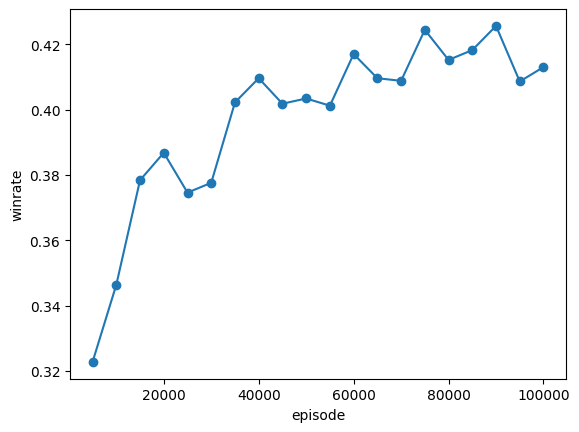

In [ ]:
env = gym.make("Blackjack-v1")
config = Config()
agent = Agent(env, config)

ep_rewards, stats = agent.train()

winrates = [stat[2] / config.print_every for stat in stats]
episodes = list(range(config.print_every, config.n_episodes + 1, config.print_every))
plt.ylabel("winrate")
plt.xlabel("episode")
plt.plot(episodes, winrates, marker='o');

In [ ]:
env = gym.make("Blackjack-v1")

num_games = 10000
total_wins = 0

for _ in tqdm(range(num_games)):
    done = False
    state, info = env.reset()

    while not done:
        action = agent.get_action(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    if reward == 1.0:
        total_wins += 1

print(f"\nДоля побед {total_wins / num_games}")

100%|██████████| 10000/10000 [00:01<00:00, 6743.09it/s]


Доля побед 0.4116


<p class="task" id="2"></p>

### 2
Повторите решение предыдущей задачи, используя алгоритм $\epsilon$-greedy Q-learning. Исследуйте, как гиперпараметры и способ инициализации значений Q-функции влияют на результат.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_aQ(s_t, a)$.

Правило обновления Q-функции:
![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [ ]:
@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    epsilon: float = 1.0
    final_epsilon: float = 0.3
    print_every: int = 5000

In [ ]:
class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.config = config
        self._create_q_table()

    def _create_q_table(self):
        self.q_table = np.random.rand(32, 11, 2, 2)

    def get_action(self, state: np.ndarray) -> int:
        p = np.random.uniform(0, 1)
        self.config.epsilon -= (self.config.epsilon - self.config.final_epsilon) * (1 / self.config.n_episodes)
        if p < self.config.epsilon:
            return np.random.randint(2)
        return np.argmax(self.q_table[state])

    def update_q_table(self, state: np.ndarray, new_state: np.ndarray, reward: float, action: int, done: bool) -> None:
        if done:
            feauture_reward = 0
        else:
            feauture_reward = np.max(self.q_table[new_state])
        self.q_new = (1 - self.config.lr) * self.q_table[state + (action, )] + self.config.lr * (reward + self.config.discount * feauture_reward)
        self.q_table[state + (action, )] = self.q_new

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done)
            state = new_state

            if done:
                return reward

    def train(self):
        ep_rewards = []
        stats = []
        for ep in tqdm(range(1, self.config.n_episodes + 1)):
            reward = self.run_episode()
            ep_rewards.append(reward)

            if ep % self.config.print_every == 0:
                stats.append(np.unique(ep_rewards[-self.config.print_every:], return_counts=True)[1])

        return ep_rewards, stats

100%|██████████| 100000/100000 [00:17<00:00, 5555.94it/s]


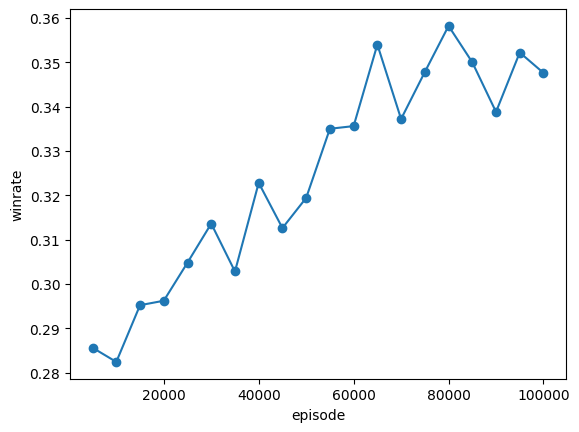

In [ ]:
env = gym.make("Blackjack-v1")
config = Config()
agent = Agent(env, config)

ep_rewards, stats = agent.train()

winrates = [stat[2] / config.print_every for stat in stats]
episodes = list(range(config.print_every, config.n_episodes + 1, config.print_every))
plt.ylabel("winrate")
plt.xlabel("episode")
plt.plot(episodes, winrates, marker='o');

In [ ]:
env = gym.make("Blackjack-v1")

num_games = 10000
total_wins = 0

for _ in tqdm(range(num_games)):
    done = False
    state, info = env.reset()

    while not done:
        action = np.argmax(agent.q_table[state])
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    if reward == 1.0:
        total_wins += 1

print(f"\nДоля побед {total_wins / num_games}")

100%|██████████| 10000/10000 [00:01<00:00, 6943.62it/s]


Доля побед 0.4246


<p class="task" id="3"></p>

### 3
Повторите решение задачи 1, используя алгоритм double Q-learning.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_a\left((Q^A_t + Q^B_t)(s_t, a))\right) $.

Правило обновления Q-функции:
$$
Q^A_{t+1}(s_{t}, a_{t}) = Q^A_{t}(s_{t}, a_{t}) + \alpha_{t}(s_{t}, a_{t}) \left(r_{t} + \gamma Q^B_{t}\left(s_{t+1}, {arg~max}_{a} Q^A_t(s_{t+1}, a)\right) - Q^A_{t}(s_{t}, a_{t})\right)
$$

$$
Q^B_{t+1}(s_{t}, a_{t}) = Q^B_{t}(s_{t}, a_{t}) + \alpha_{t}(s_{t}, a_{t}) \left(r_{t} + \gamma Q^A_{t}\left(s_{t+1}, {arg~max}_{a} Q^B_t(s_{t+1}, a)\right) - Q^B_{t}(s_{t}, a_{t})\right)
$$


- [ ] Проверено на семинаре

In [ ]:
class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.config = config
        self._create_q_table()

    def _create_q_table(self):
        self.q_table_A = np.random.rand(32, 11, 2, 2)
        self.q_table_B = np.random.rand(32, 11, 2, 2)

    def get_action(self, state: np.ndarray) -> int:
        p = np.random.uniform(0, 1)
        self.config.epsilon -= (self.config.epsilon - self.config.final_epsilon) * (1 / self.config.n_episodes)
        if p < self.config.epsilon:
            return np.random.randint(2)
        return np.argmax(self.q_table_A[state] + self.q_table_B[state])

    def update_q_table(self, state: np.ndarray, new_state: np.ndarray, reward: float, action: int, done: bool) -> None:
        self.q_new_A = (1 - self.config.lr) * self.q_table_A[state + (action, )] + self.config.lr * (reward + self.config.discount * self.q_table_B[state + (action, )])
        self.q_new_B = (1 - self.config.lr) * self.q_table_B[state + (action, )] + self.config.lr * (reward + self.config.discount * self.q_table_A[state + (action, )])
        self.q_table_A[state + (action, )] = self.q_new_A
        self.q_table_B[state + (action, )] = self.q_new_B

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done)
            state = new_state

            if done:
                return reward

    def train(self):
        ep_rewards = []
        stats = []
        for ep in tqdm(range(1, self.config.n_episodes + 1)):
            reward = self.run_episode()
            ep_rewards.append(reward)

            if ep % self.config.print_every == 0:
                stats.append(np.unique(ep_rewards[-self.config.print_every:], return_counts=True)[1])

        return ep_rewards, stats

100%|██████████| 100000/100000 [00:22<00:00, 4419.22it/s]


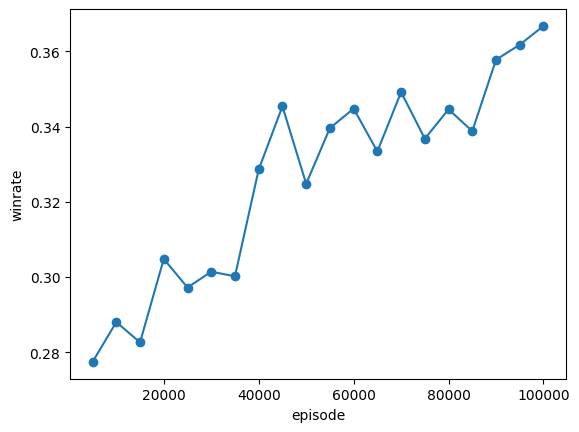

In [ ]:
env = gym.make("Blackjack-v1")
config = Config()
agent = Agent(env, config)

ep_rewards, stats = agent.train()

winrates = [stat[2] / config.print_every for stat in stats]
episodes = list(range(config.print_every, config.n_episodes + 1, config.print_every))
plt.ylabel("winrate")
plt.xlabel("episode")
plt.plot(episodes, winrates, marker='o');

In [ ]:
env = gym.make("Blackjack-v1")

num_games = 10000
total_wins = 0

for _ in tqdm(range(num_games)):
    done = False
    state, info = env.reset()

    while not done:
        action = np.argmax(agent.q_table_A[state] + agent.q_table_B[state])
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    if reward == 1.0:
        total_wins += 1

print(f"\nДоля побед {total_wins / num_games}")

100%|██████████| 10000/10000 [00:01<00:00, 6826.35it/s]


Доля побед 0.4274


<p class="task" id="4"></p>

### 4
Обучите агента для управления машиной (окружение `MountainCar-v0`) при помощи любого из рассмотренных вариантов алгоритма Q-learning. Для перехода от непрерывного пространства состояний к конечному разбейте пространство состояний на окна (количество окон выберите сами). Для определения минимальных и максимальных значений координат воспользуйтесь [информацией об окружении](https://gymnasium.farama.org/environments/classic_control/mountain_car/#observation-space). Во время обучения несколько раз вычислите среднее значение наград за эпизод за несколько последних эпизодов и количество успешных сессий за последние эпизоды. После завершения обучения визуализируйте полученные данные.

Сделайте несколько промежуточных видео с записью работы агента во время обучения.

- [ ] Проверено на семинаре

In [ ]:
@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 1000
    print_every: int = 100

In [ ]:
class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.config = config
        self._create_q_table()

    def _create_q_table(self):
        self.q_table = np.random.rand(180, 14, 3)

    def get_action(self, state: np.ndarray) -> int:
        rounded_state = np.array([round(num, 2) for num in state])
        state = np.array([0, 0])
        state[0] = int((rounded_state[0] - (-1.2)) // 0.01)
        state[1] = int((rounded_state[1] - (-0.07)) // 0.01)
        state = tuple(state)
        return np.argmax(self.q_table[state])

    def update_q_table(self, state: np.ndarray, new_state: np.ndarray, reward: float, action: int, done: bool) -> None:
        rounded_state = np.array([round(num, 2) for num in state])
        state = np.array([0, 0])
        state[0] = int((rounded_state[0] - (-1.2)) // 0.01)
        state[1] = int((rounded_state[1] - (-0.07)) // 0.01)
        state = tuple(state)

        rounded_new_state = np.array([round(num, 2) for num in new_state])
        new_state = np.array([0, 0])
        new_state[0] = int((rounded_new_state[0] - (-1.2)) // 0.01)
        new_state[1] = int((rounded_new_state[1] - (-0.07)) // 0.01)
        new_state = tuple(new_state)
        if done:
            feauture_reward = 0
        else:
            feauture_reward = np.max(self.q_table[new_state])

        self.q_new = (1 - self.config.lr) * self.q_table[state + (action, )] + self.config.lr * (reward + self.config.discount * feauture_reward)
        self.q_table[state + (action, )] = self.q_new

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done)
            state = new_state

            if done:
                return reward

    def train(self):
        # допишите код для сбора статистики
        ep_rewards = []
        stats = []
        for ep in tqdm(range(1, self.config.n_episodes + 1)):
            reward = self.run_episode()
            ep_rewards.append(reward)

            if ep % self.config.print_every == 0:
                stats.append(np.unique(ep_rewards[-self.config.print_every:], return_counts=True)[1])

        return ep_rewards, stats

In [ ]:
env = gym.make("MountainCar-v0")
config = Config()
agent = Agent(env, config)

ep_rewards, stats = agent.train()

100%|██████████| 1000/1000 [00:38<00:00, 26.22it/s]


In [ ]:
env = gym.make("MountainCar-v0")

num_games = 1000
total_wins = 0

rewards = np.array([])

for _ in tqdm(range(num_games)):
    done = False
    state, info = env.reset()

    while not done:
        action = agent.get_action(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    rewards = np.append(rewards, reward)
print(np.unique(rewards))

100%|██████████| 1000/1000 [00:23<00:00, 42.52it/s]

[-1.]


## Обратная связь
- [ ] Хочу получить обратную связь по решению